In [20]:
import pennylane as qml
from pennylane import numpy as np

import qsimcirq

import os
import time

from itertools import product


SETUPS = [{'setup_name': 'default.qubit',
           'device_type': 'default.qubit',
           'diff_method': (
               # "best",
               # "backprop",
               # "adjoint",
               # "parameter-shift",
               # "finite-diff",
           )},
          
          {'setup_name': 'default.qubit.jax',
           'device_type': 'default.qubit.jax',
           'diff_method': (
               # "best",
               # "adjoint",
               # "parameter-shift",
               # "finite-diff",
           )},  
          
          
          {'setup_name': 'lightning.qubit',
           'device_type': 'lightning.qubit',
           'diff_method': (
               # "best",
               # "adjoint",
               # "parameter-shift",
               # "finite-diff",
           )},
          {'setup_name': 'lightning.gpu - V25',
           'device_type': 'lightning.gpu',
           'diff_method': (
               # "best",
               "adjoint",
               # "parameter-shift",
               # "finite-diff",
           )},
                             
          {'setup_name': 'cirq.simulator',
           'device_type': 'cirq.simulator',
           'diff_method': (
               # "best",
               # "parameter-shift",
               # "finite-diff",
           )},
          {'setup_name': 'cirq.qsim',
           'device_type': 'cirq.qsim',
           'diff_method': (
               # "best",
               # "parameter-shift",
               # "finite-diff",
           )},
          
          {'setup_name': 'cirq.qsim - CPU 1 thread',
           'device_type': 'cirq.qsim',
           'diff_method': (
               # "best",
               # "parameter-shift",
               # "finite-diff",
               ),
           'qsim_options': qsimcirq.QSimOptions(cpu_threads=1)
          },
          
          {'setup_name': 'cirq.qsim - CPU 10 threads',
           'device_type': 'cirq.qsim',
           'diff_method': (
               # "best",
               # "parameter-shift",
               # "finite-diff",
               ),
           'qsim_options': qsimcirq.QSimOptions(cpu_threads=10)
          },
          
          {'setup_name': 'cirq.qsim - CPU 100 threads',
           'device_type': 'cirq.qsim',
           'diff_method': (
               # "best",
               # "parameter-shift",
               # "finite-diff",
               ),
           'qsim_options': qsimcirq.QSimOptions(cpu_threads=100)
          },
          
          {'setup_name': 'cirq.qsim - GPU 0',
           'device_type': 'cirq.qsim',
           'diff_method': (
               # "best",
               # "parameter-shift",
               # "finite-diff",
               ),
           'qsim_options': qsimcirq.QSimOptions(use_gpu=True, gpu_mode=0)
          },
          
          {'setup_name': 'cirq.qsim - GPU 1',
           'device_type': 'cirq.qsim',
           'diff_method': (
               # "best",
               # "parameter-shift",
               # "finite-diff",
               ),
           'qsim_options': qsimcirq.QSimOptions(use_gpu=True, gpu_mode=1)
          },
          
          {'setup_name': 'cirq.qsim - GPU 10',
           'device_type': 'cirq.qsim',
           'diff_method': (
               # "best",
               # "parameter-shift",
               # "finite-diff",
               ),
           'qsim_options': qsimcirq.QSimOptions(use_gpu=True, gpu_mode=10)
          },
          
          {'setup_name': 'cirq.qsim - GPU 100',
           'device_type': 'cirq.qsim',
           'diff_method': (
               # "best",
               # "parameter-shift",
               # "finite-diff",
               ),
           'qsim_options': qsimcirq.QSimOptions(use_gpu=True, gpu_mode=100)
          },
          
         ]

        
MIN_QUBITS_COUNT = 19
MAX_QUBITS_COUNT = 20

ROTATIONS_COUNT = 3
ANSATZ_LAYERS_COUNT = 1

qubit_counts = list(range(MIN_QUBITS_COUNT, MAX_QUBITS_COUNT + 1))

EXPERIMENTS_FOLDER = '/workspace/projects/quantum-drug-generator/benchmarks/diff_methods/'
EXPERIMENTS_FILENAME = 'experiments.npy'

EXPERIMENTS_PATH = EXPERIMENTS_FOLDER + EXPERIMENTS_FILENAME

experiments = dict()

In [21]:
# Service functions


def compose_experiments():
    
    experiments_list = []
    
    for setup in SETUPS:
        
        setup['qubit_count'] = qubit_counts        
        
        option_pairs = []
    
        for option, variants in setup.items():

            if hasattr(variants, '__iter__') and not isinstance(variants, str):

                options = tuple(product([option], variants))

            else:

                options = ((option, variants),)

            option_pairs.append(options)

        setup_experiments = list(map(dict, product(*option_pairs)))
        
        experiments_list.extend(setup_experiments)

    experiments = dict(enumerate(experiments_list))
    
    print(len(experiments))
    
    return experiments


def load_experiments(filename=EXPERIMENTS_FILENAME):
    
    experiments_path = EXPERIMENTS_FOLDER + filename
    
    experiments = np.load(experiments_path, allow_pickle='True').item()
    
    print(len(experiments))
    
    return experiments
    

def save_experiments(filename=EXPERIMENTS_FILENAME, one_experiment=None):
    
    experiments_path = EXPERIMENTS_FOLDER + filename
    
    
    if one_experiment:        
        
        experiments_dict = {0: one_experiment}
        
    else:
        
        experiments_dict = experiments
    
    
    if not os.path.exists(experiments_path):
        
        np.save(experiments_path, experiments_dict)  
        
        print(len(experiments_dict))        
        
        return
    
    
    old_experiments = np.load(experiments_path, allow_pickle='True').item()
    
    print(len(old_experiments))
    
    for experiment in experiments_dict.values():
        
        is_new_experiment = True
        
        for old_experiment in old_experiments.values():
            
            # print("experiments_dict:", experiments_dict)
            # print("experiment:", experiment)
            # print("old_experiment:", old_experiment)
            
            if all(experiment[parameter] == old_experiment[parameter]
                   for parameter in ('setup_name',
                                     'device_type', 
                                     'diff_method',
                                     'qubit_count')):
                
                is_new_experiment = False
                
                if 'total_time' in experiment:
                
                    old_experiment.update(experiment)

                
        if is_new_experiment:
            
            next_experiment_id = max(old_experiments) + 1 if old_experiments else 1
            
            old_experiments[next_experiment_id] = experiment
            
    
    np.save(experiments_path, old_experiments)
    
    print(len(old_experiments))
    

    
def delete_experiments(filename=EXPERIMENTS_FILENAME):
    
    experiments_path = EXPERIMENTS_FOLDER + filename
    
    
    if os.path.exists(experiments_path):
        
        temporary_experiments = np.load(experiments_path, allow_pickle='True').item()
    
        print(len(temporary_experiments))
        
        os.remove(experiments_path)
        
        
def enrich_total_time():
    
    for experiment_index, experiment in experiments.items():
        
        total_time = experiment['forward_time'] + experiment['backward_time']
        
        experiment['total_time'] = total_time
        
        
def enrich_setup_name():
    
    for experiment_index, experiment in experiments.items():
        
        setup_name = experiment['device_type']
        
        experiment['setup_name'] = setup_name
        

def show_unique_values(parameter='setup_name'):
    
    unique_values = {experiment[parameter] for experiment in experiments.values()}
        
    print(unique_values)
    

def pop_keys(keys=None):
    
    if keys is None:
    
        keys = ['forward_time', 'backward_time', 'total_time']
    
    cleared_experiments = dict()
    
    for experiment_index, experiment in experiments.items():
        
        cleared_experiment = experiment.copy()
        
        for key in keys:
        
            cleared_experiment.pop(key)
            
        cleared_experiments[experiment_index] = cleared_experiment
            
    print(len(cleared_experiments))
    
    return cleared_experiments


def filter_experiments(filters_dict):
    
    filtered_experiments = dict()    

    for experiment_index, experiment in experiments.items():
        
        for filter_name, filter_values in filters_dict.items():        
            
            if experiment[filter_name] not in filter_values:         
                            
                filtered_experiments[experiment_index] = experiment.copy()

    print(len(experiments))        
    print(len(filtered_experiments))

    return filtered_experiments

In [22]:
###   Circuits

def ansatz_circuit(weights, qubits):
    
    # Entangling layer
    
    if len(qubits) > 1:
        
        cnot_pairs = zip(qubits, qubits[1:] + [qubits[0]])
        
        for control_qubit, target_qubit in cnot_pairs:
            
            qml.CNOT(wires=[control_qubit, target_qubit])    

    # Variational layer
    
    for qubit, weight_rx, weight_ry, weight_rz in zip(qubits, *weights):
    
        qml.RX(weight_rx, wires=qubit)
        qml.RY(weight_ry, wires=qubit)
        qml.RZ(weight_rz, wires=qubit)


def vqc_circuit(features, weights, qubits):    
    
    # Input features encoding with angles
    
    ry_angles = (np.arctan(feature) for feature in features)
    rz_angles = (np.arctan(feature**2) for feature in features)
    
    for qubit, ry_angle, rz_angle in zip(qubits, ry_angles, rz_angles):
                
        qml.Hadamard(wires=qubit)
        qml.RY(ry_angle, wires=qubit)
        qml.RZ(rz_angle, wires=qubit)

    # Variational block
    
    qml.layer(ansatz_circuit, ANSATZ_LAYERS_COUNT, weights, qubits=qubits)
    
    return [qml.expval(qml.PauliZ(wires=qubit)) for qubit in qubits]

In [23]:
def run_experiments(save_each_experiment=False):

    for experiment_index, experiment in experiments.items():
        
        setup_name = experiment['setup_name']
        device_type = experiment['device_type']
        diff_method = experiment['diff_method']
        qubit_count = experiment['qubit_count']

        if 'total_time' in experiment:
            continue 

        # VQC Circuit Parameters

        features = np.random.random(qubit_count)
        weights = np.random.random((ANSATZ_LAYERS_COUNT, 
                                    ROTATIONS_COUNT, 
                                    qubit_count), 
                                   requires_grad=True)        

        qubits = [f"qubit_{i}" for i in range(qubit_count)]


        # Circuit
        
        allowed_device_options = ['qsim_options']
        
        device_options = {option: value for option, value in experiment.items()
                          if option in allowed_device_options}  

        vqc_device = qml.device(device_type, wires=qubits, **device_options)
        
        reserved_qnode_options = ['setup_name', 'device_type', 'qubit_count', 'qsim_options']
        
        options = {option: value for option, value in experiment.items()
                   if option not in reserved_qnode_options}      

        vqc_qnode = qml.QNode(vqc_circuit, vqc_device, **options)

        vqc_qnode_jacobian = qml.jacobian(vqc_qnode)


        # Run

        print(f"experiment: {experiment_index + 1}/{len(experiments)}")
        print("setup_name:", setup_name)
        print("device_type:", device_type)  
        print("diff_method:", diff_method)  
        print("qubit_count:", qubit_count) 

        start_time = time.time()
        forward_results = vqc_qnode(features, weights, qubits)
        forward_time = time.time() - start_time
        
        print(f"forward_time: {forward_time:.2f}")

        start_time = time.time()
        backward_results = vqc_qnode_jacobian(features, weights, qubits)
        backward_time = time.time() - start_time
        
        total_time = forward_time + backward_time
        
        experiment['forward_time'] = forward_time
        experiment['backward_time'] = backward_time    
        experiment['total_time'] = total_time
        
        print(f"backward_time: {backward_time:.2f}")
        print(f"total_time: {total_time:.2f}")

        
        if save_each_experiment:
            
            print(f'saving experiment {experiment_index + 1}')        
            save_experiments(one_experiment=experiment)
        
        print()

In [24]:
### Run

In [25]:
experiments = compose_experiments()

2


In [26]:
run_experiments(save_each_experiment=True)

experiment: 1/2
setup_name: lightning.gpu - V25
device_type: lightning.gpu
diff_method: adjoint
qubit_count: 19
forward_time: 3.38
backward_time: 7.59
total_time: 10.97
saving experiment 1
843
843

experiment: 2/2
setup_name: lightning.gpu - V25
device_type: lightning.gpu
diff_method: adjoint
qubit_count: 20
forward_time: 5.46
backward_time: 10.15
total_time: 15.62
saving experiment 2
843
843



In [38]:
save_experiments()

843
843


In [39]:
experiments = load_experiments()

843


In [40]:
# experiments = load_experiments('experiments_complete_dgx_a100.npy')

In [46]:
# save_experiments('experiments_complete_dgx_a100_v25.npy')

In [42]:
# delete_experiments()

In [43]:
# Aggregate execution times

from collections import defaultdict


execution_times = defaultdict(lambda: defaultdict(
                              lambda: defaultdict(list)))

for experiment_id, experiment in experiments.items():
    
    if 'total_time' not in experiment:
        continue     

    setup_name = experiment['setup_name']
    device_type = experiment['device_type']
    diff_method = experiment['diff_method']
    qubit_count = experiment['qubit_count']
    
    total_time = experiment['total_time']
    forward_time = experiment['forward_time']
    backward_time = experiment['backward_time']

    execution_times[setup_name][diff_method]['device_type'].append(device_type)
    execution_times[setup_name][diff_method]['qubit_count'].append(qubit_count)
    execution_times[setup_name][diff_method]['total_time'].append(total_time)
    execution_times[setup_name][diff_method]['forward_time'].append(forward_time)
    execution_times[setup_name][diff_method]['backward_time'].append(backward_time)

In [44]:
# Plot - Parameters

selected_setup_names = [
    # "default.qubit",
    # 'default.qubit.jax', 
    
    # "lightning.qubit",
    "lightning.gpu",
    
    "lightning.gpu - V25",
    
    # "cirq.simulator",
    # "cirq.qsim",
    
#     "cirq.qsim - CPU 1 thread",
#     "cirq.qsim - CPU 10 threads",
#     "cirq.qsim - CPU 100 threads",
    
#     "cirq.qsim - GPU 0",
#     "cirq.qsim - GPU 1",
#     "cirq.qsim - GPU 10",
#     "cirq.qsim - GPU 100",
]

QUBIT_PLOT_RANGE = slice(0, 22)

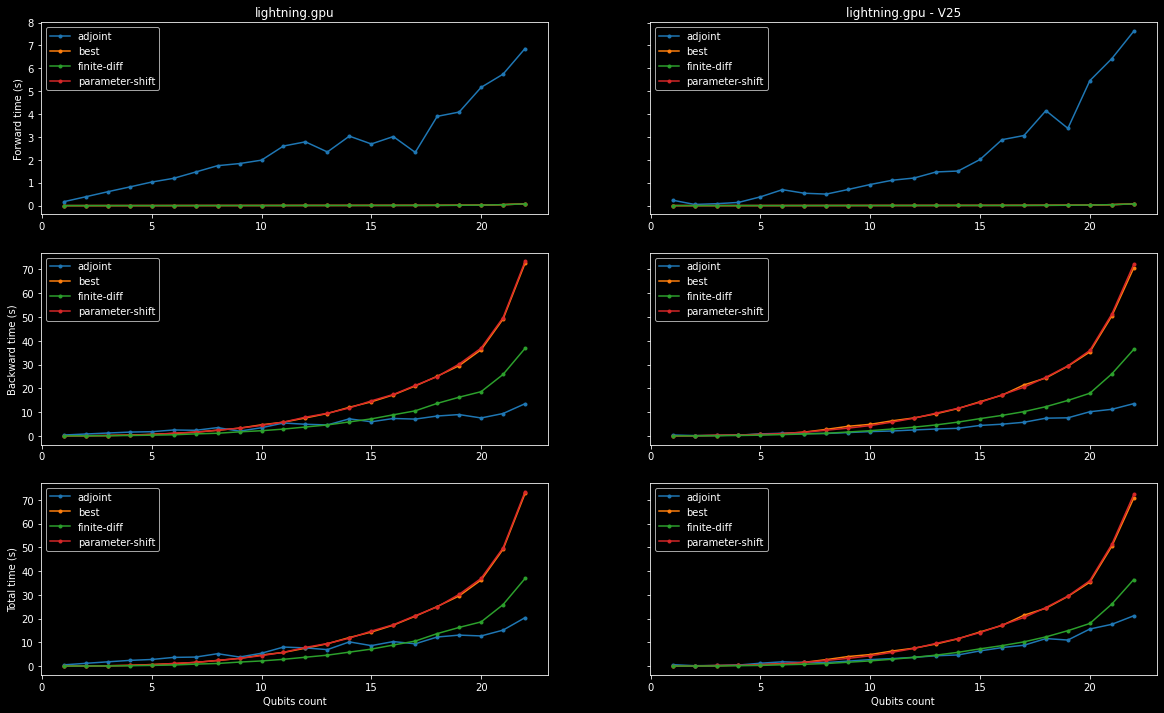

In [45]:
# Plot - Execution times per Setup name

from matplotlib import pyplot as plt


SELECTED_TIME_TYPES = [
    'forward_time',
    'backward_time',
    'total_time',
]

LOG_SCALE_Y = False

DIFF_COLORS = {'adjoint': 'tab:blue',
               'backprop': 'tab:purple',
               'best': 'tab:orange',
               'device': 'tab:black',
               'finite-diff': 'tab:green',
               'parameter-shift': 'tab:red'}

plt.style.use('dark_background')


# Draw Plot

selected_execution_times = {setup_name: execution_times[setup_name]
                            for setup_name in selected_setup_names}

setup_names_count = len(selected_execution_times)
time_types_count = len(SELECTED_TIME_TYPES)

figure, rows = plt.subplots(time_types_count, setup_names_count, 
                            figsize=(20, 12), 
                            sharex='row', sharey='row')

if setup_names_count == 1:
    rows = [rows]

for (setup_name, diff_methods_dict), *column in zip(selected_execution_times.items(), *rows):
           
    for cell, time_type in zip(column, SELECTED_TIME_TYPES):
            
        for diff_method, values in diff_methods_dict.items():
            
            # Plot Time per Qubit count

            qubit_count = values['qubit_count']
            
            times = values[time_type]
            
            cell.plot(qubit_count[QUBIT_PLOT_RANGE],
                           times[QUBIT_PLOT_RANGE],
                           '.-',
                           color=DIFF_COLORS[diff_method],
                           label=diff_method)        
   
            # Plot A to Z sorted legends

            sorted_legend = sorted((label, handle) for handle, label 
                                   in zip(*cell.get_legend_handles_labels()))

            if not sorted_legend:
                continue

            sorted_labels, sorted_handles = zip(*sorted_legend)

            cell.legend(sorted_handles, sorted_labels)
            
            # Set Y Scale

            if LOG_SCALE_Y:
                cell.set_yscale("log")
    
    # Plot labels - Device type and Qubits count
        
    column[0].set_title(setup_name)    
    column[-1].set_xlabel("Qubits count")

# Plot labels - Time type - first column

first_column = next(zip(*rows))

for cell, time_type in zip(first_column, SELECTED_TIME_TYPES):
    
    time_type_label = f"{time_type.replace('_', ' ').capitalize()} (s)"
    
    cell.set_ylabel(time_type_label)
    

# plt.tight_layout()

plt.show()

In [73]:
show_unique_values()

{'cirq.qsim - CPU 100 threads', 'default.qubit', 'cirq.qsim - GPU 10', 'cirq.qsim - CPU 1 thread', 'cirq.qsim - GPU 1', 'lightning.gpu', 'cirq.qsim - CPU 10 threads', 'cirq.simulator', 'lightning.qubit', 'cirq.qsim', 'default.qubit.jax', 'cirq.qsim - GPU 100', 'cirq.qsim - GPU 0'}


In [74]:
total_times = [experiment['total_time'] for experiment in experiments.values() if 'total_time' in experiment]

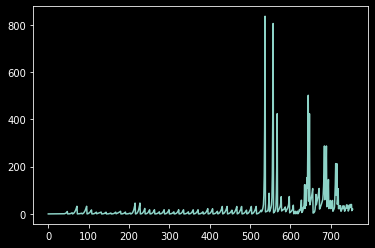

In [75]:
plt.plot(total_times)

In [77]:
np.sum(total_times)

16334.348325014114

In [82]:
dgx2_total_time = 21990.262300491333
dgx_a100_total_time = 16334.348325014114

ratio = dgx_a100_total_time / dgx2_total_time
ratio_2 = dgx2_total_time / dgx_a100_total_time

ratio, ratio_2

21
17

(0.7427991581823539, 1.3462589301353307)

In [22]:
# experiments = filter_experiments({'setup_name': [
#     "cirq.qsim - GPU",
#     "cirq.qsim - 1 GPU",
#     "cirq.qsim - 10 GPUs",
#     "cirq.qsim - 100 GPUs",
      # "cirq.qsim - 1000 CPU threads",
# ]})